# Urban Greenspace and Asthma Prevalence

Get Started with Big Data Pipelines

Vegetation has the potential to provide many ecosystem services in Urban
areas, such as cleaner air and water and flood mitigation. However, the
results are mixed on relationships between a simple measurement of
vegetation cover (such as average NDVI, a measurement of vegetation
health) and human health. We do, however, find relationships between
landscape metrics that attempt to quantify the connectivity and
structure of greenspace and human health. These types of metrics include
mean patch size, edge density, and fragmentation.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-read"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Read More</div></div><div class="callout-body-container callout-body"><p>Check out this study by <span class="citation"
data-cites="tsai_relationships_2019">@tsai_relationships_2019</span> on
the relationship between edge density and life expectancy in Baltimore,
MD. The authors also discuss the influence of scale (e.g. the resolution
of the imagery) on these relationships, which is important for this case
study.</p></div></div>

In this notebook, you will write code to calculate patch, edge, and
fragmentation statistics about urban greenspace in Chicago. These
statistics should be reflective of the connectivity and spread of urban
greenspace, which are important for ecosystem function and access. You
will then use a linear model to identify statistically significant
correlations between the distribution of greenspace and health data
compiled by the US Center for Disease Control.

### Working with larger-than-memory (big) data

For this project, we are going to split up the green space (NDVI) data
by census tract, because this matches the human health data from the
CDC. If we were interested in the average NDVI at this spatial scale, we
could easily use a source of multispectral data like Landsat (30m) or
even MODIS (250m) without a noticeable impact on our results. However,
because we need to know more about the structure of green space within
each tract, we need higher resolution data. For that, we will access the
National Agricultural Imagery Program (NAIP) data, which is taken for
the continental US every few years at 1m resolution. That’s enough to
see individual trees and cars! The main purpose of the NAIP data is, as
the name suggests, agriculture. However, it’s also a great source for
urban areas where lots is happening on a very small scale.

The NAIP data for the City of Chicago takes up about 20GB of space. This
amount of data is likely to crash your kernel if you try to load it all
in at once. It also would be inconvenient to store on your harddrive so
that you can load it in a bit at a time for analysis. Even if your are
using a computer that would be able to handle this amount of data,
imagine if you were analysing the entire United States over multiple
years!

To help with this problem, you will use cloud-based tools to calculate
your statistics instead of downloading rasters to your computer or
container. You can crop the data entirely in the cloud, thereby saving
on your memory and internet connection, using `rioxarray`.

### Check your work with testing!

This notebook does not have pre-built tests. You will need to write your
own test code to make sure everything is working the way that you want.
For many operations, this will be as simple as creating a plot to check
that all your data lines up spatially the way you were expecting, or
printing values as you go. However, if you don’t test as you go, you are
likely to end up with intractable problems with the final code.

## STEP 1: Set up your analysis

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>As always, before you get started:</p>
<ol type="1">
<li>Import necessary packages</li>
<li>Create <strong>reproducible file paths</strong> for your project
file structure.</li>
<li>To use cloud-optimized GeoTiffs, we recommend some settings to make
sure your code does not get stopped by a momentary connection lapse –
see the code cell below.</li>
</ol></div></div>

In [1]:
import os
import pathlib
import time
import warnings
from glob import glob
import zipfile
import requests

import numpy as np
import pandas as pd
from scipy.ndimage import convolve
from sklearn.model_selection import KFold
from scipy.ndimage import label
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import geopandas as gpd

In [2]:
import rioxarray as rxr
import rioxarray.merge as rxrmerge
import shapely
import xarray as xr
from cartopy import crs as ccrs

import pystac_client

warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import holoviews as hv
hv.extension()

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [4]:
import geoviews as gv
import holoviews as hv
import hvplot.pandas
import hvplot.xarray

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
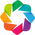

In [8]:
gv.extension('bokeh', 'matplotlib')

In [5]:
# Prevent GDAL from quitting due to momentary disruptions
os.environ["GDAL_HTTP_MAX_RETRY"] = "5"
os.environ["GDAL_HTTP_RETRY_DELAY"] = "1"

In [6]:
# Data directory 
data_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    'Projects',
    # Earth analytics projects
    'earth-analytics',
    'data',
    # Project data
    'chicago-greenspace'
)

# Downloads directory 
downloads_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    'Downloads'
)

# Define directories for data
census_dir = os.path.join(data_dir, 'cdc-census-tracts')
asthma_dir = os.path.join(data_dir, 'asthma')

os.makedirs(data_dir, exist_ok=True)
os.makedirs(downloads_dir, exist_ok=True)
os.makedirs(census_dir, exist_ok=True)
os.makedirs(asthma_dir, exist_ok=True)

## STEP 2: Create a site map

We’ll be using the Center for Disease Control (CDC) Places dataset for
human health data to compare with vegetation. CDC Places also provides
some modified census tracts, clipped to the city boundary, to go along
with the health data. We’ll start by downloading the matching geographic
data, and then select the City of Chicago.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Download the Census tract Shapefile that goes along with CDC
Places</li>
<li>Use a <strong>row filter</strong> to select only the census tracts
in Chicago</li>
<li>Use a <strong>conditional statement</strong> to cache your download.
There is no need to cache the full dataset – stick with your pared down
version containing only Chicago.</li>
</ol></div></div>

In [11]:
# Set up the census tract path
chi_tract_path = os.path.join(census_dir, 'chicago-tract.shp')

# CDC Census Tract Data 2021
TRACTS_URL = (
    "https://data.cdc.gov/download/x7zy-2xmx/application%2Fzip" 
) 

# Download the data (only once)
if not glob(chi_tract_path):
    # Load in the data
    census_gdf = gpd.read_file(TRACTS_URL)
    chi_tract_gdf = census_gdf[census_gdf.PlaceName=='Chicago']
    chi_tract_gdf.to_file(chi_tract_path, index=False)

# Load in the census data
chi_tract_gdf = gpd.read_file(chi_tract_path)

chi_tract_gdf.head()

,place2010,tract2010,ST,PlaceName,plctract10,PlcTrPop10,geometry
0,1714000,17031010100,17,Chicago,1714000-17031010100,4854,"POLYGON ((-9758835.381 5164429.383, -9758837.3..."
1,1714000,17031010201,17,Chicago,1714000-17031010201,6450,"POLYGON ((-9760143.496 5163888.741, -9760143.4..."
2,1714000,17031010202,17,Chicago,1714000-17031010202,2818,"POLYGON ((-9759754.212 5163883.196, -9759726.6..."
3,1714000,17031010300,17,Chicago,1714000-17031010300,6236,"POLYGON ((-9758695.229 5163870.91, -9758695.78..."
4,1714000,17031010400,17,Chicago,1714000-17031010400,5042,"POLYGON ((-9757724.634 5160715.939, -9757742.2..."


In [18]:
chi_tract_gdf.to_crs(ccrs.Mercator()).crs

<Projected CRS: +proj=merc +ellps=WGS84 +lon_0=0.0 +x_0=0.0 +y_0=0 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Mercator (variant A)
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [20]:
# Site plot 
chi_census_tract_plt = (
    chi_tract_gdf
    .to_crs(ccrs.Mercator())
    .hvplot(
        title='Chicago Census Tracts',
        line_color='#fc6f10', fill_color=None, 
        crs=ccrs.Mercator(), tiles='EsriImagery',
        frame_width=600, frame_height=650)
)

chi_census_tract_plt

DataError: Supplied data does not contain specified dimensions, the following dimensions were not found: ['Longitude', 'Latitude']

PandasInterface expects tabular data, for more information on supported datatypes see http://holoviews.org/user_guide/Tabular_Datasets.html

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>What do you notice about the City of Chicago from the coarse
satellite image? Is green space evenly distributed? What can you learn
about Chicago from websites, scientific papers, or other resources that
might help explain what you see in the site map?</p></div></div>

**WRITE YOUR CITY OF CHICAGO DATA DESCRIPTION AND CITATION HERE**

## STEP 3 - Access Asthma and Urban Greenspaces Data

### Access human health data

The U.S. Center for Disease Control (CDC) provides a number of health
variables through their [Places
Dataset](https://www.cdc.gov/places/index.html) that might be correlated
with urban greenspace. For this assignment, start with adult asthma. Try
to limit the data as much as possible for download. Selecting the state
and county is a one way to do this.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>You can access Places data with an API, but as with many APIs it is
easier to test out your search before building a URL. Navigate to the <a
href="https://data.cdc.gov/500-Cities-Places/PLACES-Local-Data-for-Better-Health-Census-Tract-D">Places
Census Tract Data Portal</a> and search for the data you want.</li>
<li>The data portal will make an API call for you, but there is a
simpler, easier to read and modify way to form an API call. Check out to
the <a href="https://dev.socrata.com/docs/endpoints">socrata
documentation</a> to see how. You can also find some limited examples
and a list of available parameters for this API on <a
href="https://dev.socrata.com/foundry/data.cdc.gov/cwsq-ngmh">CDC Places
SODA Consumer API Documentation</a>.</li>
<li>Once you have formed your query, you may notice that you have
exactly 1000 rows. The Places SODA API limits you to 1000 records in a
download. Either narrow your search or check out the
<code>&amp;$limit=</code> parameter to increase the number of rows
downloaded. You can find more information on the <a
href="https://dev.socrata.com/docs/paging">Paging page of the SODA API
documentation</a></li>
<li>You should also clean up this data by renaming the
<code>'data_value'</code> to something descriptive, and possibly
selecting a subset of columns.</li>
</ol></div></div>

In [34]:
# Chicago counties (Chicago Metropolitan Agency for Planning)
CHICAGO_COUNTIES = [
    "Cook", "DuPage", "Kane", "Kendall", "Lake", "McHenry", "Will"
]

# Set up a path for the asthma data
asthma_data_pattern = os.path.join(asthma_dir, '*')

# Download asthma data (only once)
if not glob(asthma_data_pattern):

    il_asthma_req = requests.get(
        "https://chronicdata.cdc.gov/resource/cwsq-ngmh.geojson"
        "?$limit=500000"
        "&measure=Current asthma among adults"
        "&statedesc=Illinois"
        "&year=2022"
    )

# Load in asthma data
    
# GeoJSON dictionary
illinois_asthma_geodict = il_asthma_req.json()

il_asthma_gdf = gpd.GeoDataFrame.from_features(
                    illinois_asthma_geodict["features"]
                )

chi_asthma_gdf = il_asthma_gdf[
                    il_asthma_gdf['countyname'].isin(CHICAGO_COUNTIES)
                ]

# Preview asthma data
chi_asthma_gdf.head(1)

,geometry,measure,low_confidence_limit,data_value_unit,data_value,short_question_text,statedesc,totalpop18plus,locationid,countyname,...,data_value_footnote,data_value_type,data_value_footnote_symbol,locationname,category,datavaluetypeid,measureid,countyfips,datasource,totalpopulation
0,POINT (-88.32041 41.76582),Current asthma among adults,9.4,%,10.6,Current Asthma,Illinois,4266,17089853200,Kane,...,None,Crude prevalence,None,17089853200,Health Outcomes,CrdPrv,CASTHMA,17089,BRFSS,6044


In [35]:
chi_asthma_gdf.columns

Index(['geometry', 'measure', 'low_confidence_limit', 'data_value_unit',
       'data_value', 'short_question_text', 'statedesc', 'totalpop18plus',
       'locationid', 'countyname', 'year', 'high_confidence_limit',
       'categoryid', 'stateabbr', 'data_value_footnote', 'data_value_type',
       'data_value_footnote_symbol', 'locationname', 'category',
       'datavaluetypeid', 'measureid', 'countyfips', 'datasource',
       'totalpopulation'],
      dtype='object')

In [36]:
cdc_df = chi_asthma_gdf.rename(columns={
    'data_value': 'asthma',
    'low_confidence_limit': 'asthma_ci_low',
    'high_confidence_limit': 'asthma_ci_high',
    'locationname': 'tract'
})[[
    'year', 'tract', 'asthma', 'asthma_ci_low',
    'asthma_ci_high', 'totalpopulation', 'totalpop18plus'
]]

cdc_df.head(1)

,year,tract,asthma,asthma_ci_low,asthma_ci_high,totalpopulation,totalpop18plus
0,2022,17089853200,10.6,9.4,12.1,6044,4266


In [37]:
chi_tract_gdf.head(1)

,place2010,tract2010,ST,PlaceName,plctract10,PlcTrPop10,geometry
0,1714000,17031010100,17,Chicago,1714000-17031010100,4854,"POLYGON ((-9758835.381 5164429.383, -9758837.3..."


### Join health data with census tract boundaries

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Join the census tract <code>GeoDataFrame</code> with the asthma
prevalence <code>DataFrame</code> using the <code>.merge()</code>
method.</li>
<li>You will need to change the data type of one of the merge columns to
match, e.g. using <code>.astype('int64')</code></li>
<li>There are a few census tracts in Chicago that do not have data. You
should be able to confirm that they are not listed through the
interactive Places Data Portal. However, if you have large chunks of the
city missing, it may mean that you need to expand the record limit for
your download.</li>
</ol></div></div>

In [38]:
# Change tract identifier datatype for merging

chi_tract_gdf.tract2010 = chi_tract_gdf.tract2010.astype('int64')
cdc_df.tract = cdc_df.tract.astype('int64')

In [39]:
# Merge census data with geometry

census_asthma_gdf = chi_tract_gdf.merge(
    cdc_df, left_on='tract2010', right_on='tract', how='inner')

census_asthma_gdf.head(2)

,place2010,tract2010,ST,PlaceName,plctract10,PlcTrPop10,geometry,year,tract,asthma,asthma_ci_low,asthma_ci_high,totalpopulation,totalpop18plus
0,1714000,17031010100,17,Chicago,1714000-17031010100,4854,"POLYGON ((-9758835.381 5164429.383, -9758837.3...",2022,17031010100,10.3,9.2,11.5,4905,4083
1,1714000,17031010201,17,Chicago,1714000-17031010201,6450,"POLYGON ((-9760143.496 5163888.741, -9760143.4...",2022,17031010201,11.1,9.9,12.4,6939,5333


In [40]:
census_asthma_gdf.dropna(subset=['asthma'], inplace=True)

In [41]:
# Plot asthma data as choropleth

(
    gv.tile_sources.EsriImagery
    * 
    gv.Polygons(
        census_asthma_gdf.to_crs(ccrs.Mercator()),
        vdims=['asthma', 'tract2010'],
        crs=ccrs.Mercator()
    ).opts(color='asthma', colorbar=True, tools=['hover'])
).opts(
    title='Chicago Asthma Rates',
    width=600, height=650
)

bokeh backend could not plot any Elements in the Overlay.

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (asthma,tract2010)

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>Write a description and citation for the asthma prevalence data. Do
you notice anything about the spatial distribution of asthma in Chicago?
From your research on the city, what might be some potential causes of
any patterns you see?</p></div></div>

**ADD YOUR CDC PLACES DESCRIPTION AND CITATION HERE**

### Get Data URLs

NAIP data are freely available through the Microsoft Planetary Computer
SpatioTemporal Access Catalog (STAC). The National Agriculture Imagery Program (NAIP) provides U.S.-wide, high-resolution aerial imagery, with four spectral bands (R, G, B, IR).

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Get started with STAC by accessing the planetary computer catalog
with the following code:</p>
<div class="sourceCode" id="cb1"><pre
class="sourceCode python"><code class="sourceCode python"><span id="cb1-1"><a href="#cb1-1" aria-hidden="true" tabindex="-1"></a>e84_catalog <span class="op">=</span> pystac_client.Client.<span class="bu">open</span>(</span>
<span id="cb1-2"><a href="#cb1-2" aria-hidden="true" tabindex="-1"></a>    <span class="st">&quot;https://planetarycomputer.microsoft.com/api/stac/v1&quot;</span></span>
<span id="cb1-3"><a href="#cb1-3" aria-hidden="true" tabindex="-1"></a>)</span></code></pre></div></div></div>

In [22]:
# Connect to the planetary computer catalog

e84_catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li><p>Using a loop, for each Census Tract:</p>
<ol type="1">
<li><p>Use the following sample code to search for data, replacing the
names with applicable values with descriptive names:</p>
<div class="sourceCode" id="cb1"><pre
class="sourceCode python"><code class="sourceCode python"><span id="cb1-1"><a href="#cb1-1" aria-hidden="true" tabindex="-1"></a>search <span class="op">=</span> e84_catalog.search(</span>
<span id="cb1-2"><a href="#cb1-2" aria-hidden="true" tabindex="-1"></a>    collections<span class="op">=</span>[<span class="st">&quot;naip&quot;</span>],</span>
<span id="cb1-3"><a href="#cb1-3" aria-hidden="true" tabindex="-1"></a>    intersects<span class="op">=</span>shapely.to_geojson(tract_geometry),</span>
<span id="cb1-4"><a href="#cb1-4" aria-hidden="true" tabindex="-1"></a>    datetime<span class="op">=</span><span class="ss">f&quot;</span><span class="sc">{</span>year<span class="sc">}</span><span class="ss">&quot;</span></span>
<span id="cb1-5"><a href="#cb1-5" aria-hidden="true" tabindex="-1"></a>)</span></code></pre></div></li>
<li><p>Access the url using
<code>search.assets['image'].href</code></p></li>
</ol></li>
<li><p>Accumulate the urls in a <code>pd.DataFrame</code> or
<code>dict</code> for later</p></li>
<li><p>Occasionally you may find that the STAC service is momentarily
unavailable. You should include code that will retry the request up to 5
times when you get the
<code>pystac_client.exceptions.APIError</code>.</p></li>
</ol></div></div>

> **Warning**
>
> As always – DO NOT try to write this loop all at once! Stick with one
> step at a time, making sure to test your work. You also probably want
> to add a `break` into your loop to stop the loop after a single
> iteration. This will help prevent long waits during debugging.

In [23]:
census_asthma_gdf.columns

Index(['place2010', 'tract2010', 'ST', 'PlaceName', 'plctract10', 'PlcTrPop10',
       'geometry', 'year', 'tract', 'asthma', 'asthma_ci_low',
       'asthma_ci_high', 'totalpopulation', 'totalpop18plus'],
      dtype='object')

In [24]:
# Convert geometry to lat/lon for STAC

tract_latlon_gdf = census_asthma_gdf.to_crs(4326) # WGS84 projection

# Define a path to save NDVI stats
ndvi_stats_path = os.path.join(data_dir, 'chicago-ndvi-stats.csv')

# Check for existing data - do not access duplicate tracts
tracts_downloaded = []
if os.path.exists(ndvi_stats_path):
    ndvi_stats_df = pd.read_csv(ndvi_stats_path)
    tracts_downloaded = ndvi_stats_df.tract.values
else:
    print('No downloaded census tracts.')

# Loop through each census tract
scene_dfs = []
for index, row in tqdm(tract_latlon_gdf.iterrows()):
    tract = row.tract
    year = 2021

    # Check if statistics are already downloaded for this tract
    if not (tract in tracts_downloaded):

        # Repeat up to 5 times in case of a momentary disruption   
        retry = 0
        retry_limit = 5
        while retry < retry_limit:
            try:
                # Try accessing the STAC
                naip_search = e84_catalog.search(
                            collections=["naip"], 
                            intersects=shapely.to_geojson(row.geometry),
                            datetime=f"{year}"
                        )
                
                # Search for tiles 
                tiles = naip_search.get_all_items()

                # Build dataframe with tracts and tile urls
                tract_tiles_df = pd.DataFrame(dict(
                    tract=tract,
                    date=[pd.to_datetime(scene.datetime).date() or None
                          for scene in tiles],
                    # spectral bands (R, G, B, IR)
                    rgbir_href=[scene.assets['image'].href or None
                                for scene in tiles],
                ))

                scene_dfs.append(tract_tiles_df)

                break 
            except pystac_client.exceptions.APIError as e:
                print("STAC API Error: ", 
                      e.response.status_code, e.response.text)
                print(f"Retrying with tract {tract}")
                continue
        else:
            print("All attempts failed.")

# Concatenate scene DataFrames
if scene_dfs:
    scene_df = pd.concat(scene_dfs).reset_index(drop=True)
else:
    scene_df = None

scene_df

0it [00:00, ?it/s]

,tract,date,rgbir_href
0,17031081100,2021-09-08,https://naipeuwest.blob.core.windows.net/naip/...
1,17031081100,2021-09-08,https://naipeuwest.blob.core.windows.net/naip/...
2,17031081201,2021-09-08,https://naipeuwest.blob.core.windows.net/naip/...
3,17031081201,2021-09-08,https://naipeuwest.blob.core.windows.net/naip/...
4,17031081202,2021-09-08,https://naipeuwest.blob.core.windows.net/naip/...
...,...,...,...
1045,17031808100,2021-09-08,https://naipeuwest.blob.core.windows.net/naip/...
1046,17031808100,2021-09-08,https://naipeuwest.blob.core.windows.net/naip/...
1047,17043840000,2021-09-08,https://naipeuwest.blob.core.windows.net/naip/...
1048,17043840000,2021-09-08,https://naipeuwest.blob.core.windows.net/naip/...


### Compute NDVI Statistics

Next, calculate some metrics to get at different aspects of the
distribution of greenspace in each census tract. These types of
statistics are called **fragmentation statistics**, and can be
implemented with the `scipy` package. Some examples of fragmentation
statistics are:

Percentage vegetation  
The percentage of pixels that exceed a vegetation threshold (.12 is
common with Landsat) Mean patch size

The average size of **patches**, or contiguous area exceeding the
vegetation threshold. Patches can be identified with the `label`
function from `scipy.ndimage` Edge density

The proportion of edge pixels among vegetated pixels. Edges can be
identified by **convolving** the image with a **kernel** designed to
detect pixels that are different from their surroundings.

> **What is convolution?**
>
> If you are familiar with differential equations, convolution is an
> approximation of the LaPlace transform.
>
> For the purposes of calculating edge density, convolution means that
> we are taking all the possible 3x3 chunks for our image, and
> multiplying it by the kernel:
>
> $$
> \text{Kernel} =
> \begin{bmatrix}
> 1 & 1 & 1 \\
> 1 & -8 & 1 \\
> 1 & 1 & 1
> \end{bmatrix}
> $$
>
> The result is a matrix the same size as the original, minus the
> outermost edge. If the center pixel is the same as the surroundings,
> its value in the final matrix will be
> $-8 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 = 0$. If it is higher than the
> surroundings, the result will be negative, and if it is lower than the
> surroundings, the result will be positive. As such, the edge pixels of
> our patches will be negative.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Select a single row from the census tract <code>GeoDataFrame</code>
using e.g. <code>.loc[[0]]</code>, then select all the rows from your
URL <code>DataFrame</code> that match the census tract.</li>
<li>For each URL in crop, merge, clip, and compute NDVI for that census
tract</li>
<li>Set a threshold to get a binary mask of vegetation</li>
<li>Using the sample code to compute the fragmentation statistics. Feel
free to add any other statistics you think are relevant, but make sure
to include a fraction vegetation, mean patch size, and edge density. If
you are not sure what any line of code is doing, make a plot or print
something to find out! You can also ask ChatGPT or the class.</li>
</ol></div></div>

In [43]:
shared_tracts = scene_df[scene_df['tract'].isin(census_asthma_gdf['tract'])]['tract']
tract_ID = shared_tracts[0]

In [48]:
tract_ID = shared_tracts[0]
example_tract = census_asthma_gdf[census_asthma_gdf.tract == tract_ID]

tract_subset = scene_df[scene_df.tract == tract_ID]

tract_subset

,tract,date,rgbir_href
0,17031081100,2021-09-08,https://naipeuwest.blob.core.windows.net/naip/...
1,17031081100,2021-09-08,https://naipeuwest.blob.core.windows.net/naip/...


In [46]:
# Skip this step if data are already downloaded 
if not scene_df is None:

    # Get an example census tract
    tract_ID = shared_tracts[0]
    example_tract = census_asthma_gdf[census_asthma_gdf.tract == tract_ID]

    tract_subset = scene_df[scene_df.tract == tract_ID]

    if len(tract_subset):

        # Loop through all images for tract
        tile_das = [] 
        for index, tract in tract_subset.iterrows():
            tract_URL = tract.rgbir_href

            # Open vsi connection to data
            tile_da = rxr.open_rasterio(
                tract_URL, masked=True
                # remove 1-D entries from the shape of the array
            ).squeeze()

            # Crop data to the bounding box of the census tract
            tract_geo_bounds = example_tract.geometry.to_crs(
                tile_da.rio.crs
            ).geometry

            cropped_da = tile_da.rio.clip_box(
                # the envelope of a geometry is the bounding rectangle
                *tract_geo_bounds.envelope.total_bounds,
                # expand clip search if only 1D raster found with clip
                auto_expand=True
            )

            # Clip data to the boundary of the census tract
            clipped_da = cropped_da.rio.clip(
                tract_geo_bounds, 
                # all pixels touched by geometries will be burned onto the data
                # so that only the portion within the clip area is accessible
                all_touched=True
            )

            # Compute NDVI
            # formula (NDVI=(NIR-Red)/(NIR+Red))
            # spectral bands (R=1, G=2, B=3, IR=4)
            ndvi_da = (
                (clipped_da.sel(band=4) - clipped_da.sel(band=1)) 
                / (clipped_da.sel(band=4) + clipped_da.sel(band=1))
            )

            # Accumulate result
            tile_das.append(ndvi_da)

        # Merge data
        scene_da = rxrmerge.merge_arrays(tile_das)

        # Mask vegetation
        veg_mask = (scene_da>.3)

        # Calculate mean patch size
        labeled_patches, num_patches = label(veg_mask)
        # Count patch pixels, ignoring background at patch 0
        # ravel() returns a contiguous flattened 1-D array
        patch_sizes = np.bincount(labeled_patches.ravel())[1:]
        mean_patch_size = patch_sizes.mean()

        # Calculate edge density
        kernel = np.array([
            [1, 1, 1], 
            [1, -8, 1], 
            [1, 1, 1]])
        edges = convolve(veg_mask, kernel, mode='constant')
        edge_density = np.sum(edges != 0) / veg_mask.size

scene_da

<xarray.DataArray (y: 1350, x: 238)> Size: 1MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * x            (x) float64 2kB 4.477e+05 4.477e+05 ... 4.479e+05 4.479e+05
  * y            (y) float64 11kB 4.639e+06 4.639e+06 ... 4.638e+06 4.638e+06
    spatial_ref  int64 8B 0

### Repeat for all tracts

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li><p>Using a loop, for each Census Tract:</p>
<ol type="1">
<li><p>Using a loop, for each data URL:</p>
<ol type="1">
<li>Use <code>rioxarray</code> to open up a connection to the STAC
asset, just like you would a file on your computer</li>
<li>Crop and then clip your data to the census tract boundary &gt; HINT:
check out the <code>.clip_box</code> parameter <code>auto_expand</code>
and the <code>clip</code> parameter <code>all_touched</code> to make
sure you don’t end up with an empty array</li>
<li>Compute NDVI for the tract</li>
</ol></li>
<li><p>Merge the NDVI rasters</p></li>
<li><p>Compute:</p>
<ol type="1">
<li>total number of pixels within the tract</li>
<li>fraction of pixels with an NDVI greater than .12 within the tract
(and any other statistics you would like to look at)</li>
</ol></li>
<li><p>Accumulate the statistics in a file for later</p></li>
</ol></li>
<li><p>Using a conditional statement, ensure that you do not run this
computation if you have already saved values. You do not want to run
this step many times, or have to restart from scratch! There are many
approaches to this, but we actually recommend implementing your caching
in the previous cell when you generate your dataframe of URLs, since
that step can take a few minutes as well. However, the important thing
to cache is the computation.</p></li>
</ol></div></div>

In [68]:
# Skip this step if data are already downloaded 
if not scene_df is None:
    ndvi_dfs = []

    # Loop through the census tracts with URLs
    for tract, tract_date_gdf in tqdm(scene_df.groupby('tract')):

        if len(tract_date_gdf):

            # Open all images for tract
            tile_das = []

            for _, tile_data in tract_date_gdf.iterrows():
                # Open vsi connection to data
                tile_da = rxr.open_rasterio(
                    tile_data.rgbir_href, masked=True
                ).squeeze()
                
                # Select first row in census with tract value
                census_tract = census_asthma_gdf[
                    census_asthma_gdf.tract == tract
                ].iloc[[0]]

                # Crop data to the bounding box of the census tract
                tract_geo_bounds = census_tract.geometry.to_crs(
                    tile_da.rio.crs
                    ).geometry

                cropped_da = tile_da.rio.clip_box(
                    # the envelope of a geometry is the bounding rectangle
                    *tract_geo_bounds.envelope.total_bounds,
                    # expand clip search if only 1D raster found with clip
                    auto_expand=True
                )

                # Clip data to the boundary of the census tract
                clipped_da = cropped_da.rio.clip(
                    tract_geo_bounds, 
                    # all pixels touched by geometries will be burned onto the data
                    # so that only the portion within the clip area is accessible
                    all_touched=True
                )
                
                # Compute NDVI
                # formula (NDVI=(NIR-Red)/(NIR+Red))
                # spectral bands (R=1, G=2, B=3, IR=4)
                ndvi_da = (
                    (clipped_da.sel(band=4) - clipped_da.sel(band=1)) 
                    / (clipped_da.sel(band=4) + clipped_da.sel(band=1))
                )

                # Accumulate result
                tile_das.append(ndvi_da)

            # Merge NDVI data
            scene_da = rxrmerge.merge_arrays(tile_das)

            # Mask vegetation (pixels that exceed veg threshold)
            veg_mask = (scene_da>.3)

            # Calculate statistics
            # NDVI
            total_pixels = scene_da.notnull().sum()
            # Vegetation
            veg_pixels = veg_mask.sum()

            # Calculate mean contiguous area greater than veg threshold
            labeled_patches, num_patches = label(veg_mask)
            # Count patch pixels, ignoring background at patch 0
            # ravel() returns a contiguous flattened 1-D array
            patch_sizes = np.bincount(labeled_patches.ravel())[1:]
            mean_patch_size = patch_sizes.mean()

            # Calculate edge density
            kernel = np.array([
                [1, 1, 1], 
                [1, -8, 1], 
                [1, 1, 1]])
            edges = convolve(veg_mask, kernel, mode='constant')
            edge_density = np.sum(edges != 0) / veg_mask.size
            
            # Gather tract statistics 
            tract_stats = pd.DataFrame(dict(
                tract=[tract],
                total_pixels=[int(total_pixels)],
                # percentage of pixels that exceed a vegetation threshold
                frac_veg=[float(veg_pixels/total_pixels)],
                mean_patch_size=[mean_patch_size],
                # proportion of edge pixels among vegetated pixels
                # aka greenspace fragmentation
                edge_density=[edge_density]
            ))

            # Add a row to the statistics file for this tract
            tract_stats.to_csv(
                ndvi_stats_path,
                mode='a',
                index=False,
                # only add header if does not exist already
                header=(not os.path.exists(ndvi_stats_path))
            )

  0%|          | 0/659 [00:00<?, ?it/s]

In [13]:
# Load results from file
ndvi_stats_df = pd.read_csv(ndvi_stats_path)
ndvi_stats_df.head()

,tract,total_pixels,frac_veg,mean_patch_size,edge_density
0,17031010100,1059109,0.178500,55.326602,0.118459
1,17031010201,1533140,0.213616,57.537421,0.161389
2,17031010202,978523,0.186242,63.256508,0.123770
3,17031010300,1308371,0.191591,57.061689,0.126558
4,17031010400,1516950,0.198593,53.019183,0.079399


## STEP 4 - Explore your data with plots

### Chloropleth plots

Before running any statistical models on your data, you should check
that your download worked. You should see differences in both median
income and mean NDVI across the City.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Create a plot that contains:</p>
<ul>
<li>2 side-by-side Chloropleth plots</li>
<li>Asthma prevelence on one and mean NDVI on the other</li>
<li>Make sure to include a title and labeled color bars</li>
</ul></div></div>

In [18]:
# Merge census data with geometry

# Plot chloropleths with vegetation statistics

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-response"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div></div><div class="callout-body-container callout-body"><p>Do you see any similarities in your plots? Do you think there is a
relationship between adult asthma and any of your vegetation statistics
in Chicago? Relate your visualization to the research you have done (the
context of your analysis) if applicable.</p></div></div>

**ADD YOUR PLOT DESCRIPTION HERE**

## STEP 5: Explore a linear ordinary least-squares regression

### Model description

One way to find if there is a statistically significant relationship
between asthma prevalence and greenspace metrics is to run a linear
ordinary least squares (OLS) regression and measure how well it is able
to predict asthma given your chosen fragmentation statistics.

Before fitting an OLS regression, you should check that your data are
appropriate for the model.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Write a model description for the linear ordinary least-squares
regression that touches on:</p>
<ol type="1">
<li>Assumptions made about the data</li>
<li>What is the objective of this model? What metrics could you use to
evaluate the fit?</li>
<li>Advantages and potential problems with choosing this model.</li>
</ol></div></div>

**ADD YOUR CDC PLACES DESCRIPTION AND CITATION HERE**

### Data preparation

When fitting statistical models, you should make sure that your data
meet the model assumptions through a process of selection and/or
transformation.

You can select data by:

-   Eliminating observations (rows) or variables (columns) that are
    missing data
-   Selecting a model that matches the way in which variables are
    related to each other (for example, linear models are not good at
    modeling circles)
-   Selecting variables that explain the largest amount of variability
    in the dependent variable.

You can transform data bt:

-   Transforming a variable so that it follows a normal distribution.
    The `log` transform is the most common to eliminate excessive skew
    (e.g. make the data symmetrical), but you should select a transform
    most suited to your data.
-   Normalizing or standardizing variables to, for example, eliminate
    negative numbers or effects caused by variables being in a different
    range.
-   Performing a principle component analysis (PCA) to eliminate
    multicollinearity among the predictor variables

> **Tip**
>
> Keep in mind that data transforms like a log transform or a PCA must
> be reversed after modeling for the results to be meaningful.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Use the <code>hvplot.scatter_matrix()</code> function to create an
exploratory plot of your data.</li>
<li>Make any necessary adjustments to your data to make sure that they
meet the assumptions of a linear OLS regression.</li>
<li>Check if there are <code>NaN</code> values, and if so drop those
rows and/or columns. You can use the <code>.dropna()</code> method to
drop rows with <code>NaN</code> values.</li>
<li>Explain any data transformations or selections you made and why</li>
</ol></div></div>

In [20]:
# Variable selection and transformation

**EXPLAIN YOUR SELECTION AND TRANSFORMATION PROCESS HERE**

### Fit and Predict

If you have worked with statistical models before, you may notice that
the `scikitlearn` library has a slightly different approach than many
software packages. For example, `scikitlearn` emphasizes generic model
performance measures like cross-validation and importance over
coefficient p-values and correlation. The scikitlearn approach is meant
to generalize more smoothly to machine learning (ML) models where the
statistical significance is harder to derive mathematically.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Use the scikitlearn documentation or ChatGPT as a starting point,
split your data into training and testing datasets.</li>
<li>Fit a linear regression to your training data.</li>
<li>Use your fitted model to predict the testing values.</li>
<li>Plot the predicted values against the measured values. You can use
the following plotting code as a starting point.</li>
</ol></div></div>

In [22]:
# Select predictor and outcome variables

# Split into training and testing datasets

# Fit a linear regression

# Predict asthma values for the test dataset

# Plot measured vs. predicted asthma prevalence with a 1-to-1 line
(
    test_df
    .hvplot.scatter(x='measured', y='predicted')
    .opts(aspect='equal', 
          xlim=(0, y_max), ylim=(0, y_max), 
          width=600, height=600)
) * hv.Slope(slope=1, y_intercept=0).opts(color='black')

### Spatial bias

We always need to think about bias, or systematic error, in model
results. Every model is going to have some error, but we’d like to see
that error evenly distributed. When the error is systematic, it can be
an indication that we are missing something important in the model.

In geographic data, it is common for location to be a factor that
doesn’t get incorporated into models. After all – we generally expect
places that are right next to each other to be more similar than places
that are far away (this phenomenon is known as *spatial
autocorrelation*). However, models like this linear regression don’t
take location into account at all.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Compute the model error (predicted - measured) for all census
tracts</li>
<li>Plot the error as a chloropleth map with a diverging color
scheme</li>
<li>Looking at both of your error plots, what do you notice? What are
some possible explanations for any bias you see in your model?</li>
</ol></div></div>

In [24]:
# Compute model error for all census tracts

# Plot error geographically as a chloropleth

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>What do you notice about your model from looking at the error plots?
What additional data, transformations, or model type might help improve
your results?</p></div></div>

**DESCRIBE AND INTERPRET YOUR IMAGE HERE**